In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [2]:
# Step 1: Define problem parameters
L = 50  # Length of domain in x and y directions
Nx, Ny = 50, 50  # Number of grid points in x and y
alpha = 2  # Thermal diffusivity
dt = 0.0125  # Time step size
nt = 3000  # Number of time steps

In [3]:
# Step 2: Generate grid (structured triangular mesh)
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)
triangulation = tri.Triangulation(X.flatten(), Y.flatten())

In [4]:
# Step 3: Initial condition
u0 = np.zeros((L * L))
u0[:L] = 100

In [5]:
def assemble_matrices(triangulation, alpha):
    npoints = len(triangulation.x)  # Total number of points in the mesh
    K = np.zeros((npoints, npoints))  # Global stiffness matrix
    M = np.zeros((npoints, npoints))  # Global mass matrix
    
    for element in triangulation.triangles:
        # Get the coordinates of the three vertices of the triangle
        vertices = element[:]
        x_coords = triangulation.x[vertices]
        
        y_coords = triangulation.y[vertices]
        # Compute area of the triangle (used in both stiffness and mass matrices)
        area = 0.5 * abs(
            x_coords[0] * (y_coords[1] - y_coords[2]) +
            x_coords[1] * (y_coords[2] - y_coords[0]) +
            x_coords[2] * (y_coords[0] - y_coords[1])
        )
        # Local stiffness matrix (based on gradients of linear basis functions)
        Ke = (alpha / (4 * area)) * np.array([[2, -1, -1],
                                              [-1, 2, -1],
                                              [-1, -1, 2]])
        
        # Local mass matrix (based on linear basis functions)
        Me = (area / 12) * np.array([[2, 1, 1],
                                     [1, 2, 1],
                                     [1, 1, 2]])
        
        # Add local contributions to the global matrices
        for i in range(3):
            for j in range(3):
                K[vertices[i], vertices[j]] += Ke[i, j]
                M[vertices[i], vertices[j]] += Me[i, j]
    
    return K, M

In [6]:
K, M = assemble_matrices(triangulation, alpha)
M[:L,:]  = 0.0
for i in range(L):
    M[i, i] = 1.0

In [7]:
# Step 5: Time-stepping loop (Forward Euler)
U = np.zeros((nt, L, L))
U[0,:,:] = u0.reshape((L, L))

M_inv = np.linalg.inv(M)
u = u0
for n in range(1, nt):
    Ku = K @ u
    Ku[:L] = 0.0
    u = u - dt * np.dot(M_inv, Ku)
    
    U[n,:,:] = u.reshape((L, L))

In [8]:
def plotheatmap(tr, u_k , k):
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.tripcolor(tr, u_k.flatten(), cmap=plt.cm.jet, vmin=0, vmax=100, shading='gouraud')
    plt.colorbar()

In [9]:
def animate(k):
    plotheatmap(triangulation, U[k], k)

MovieWriter ffmpeg unavailable; using Pillow instead.


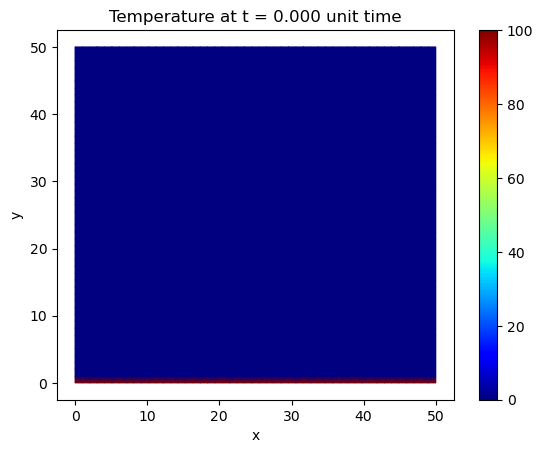

In [10]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=nt, repeat=False)
anim.save("heat_equation_solution_FE.gif")